# Imports & static parameters

In [1]:
import os
import numpy as np
import pandas as pd
import json
import glob
from utils import *
from tkinter import Tk
from tkinter.filedialog import askopenfilename

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import proj3d
# interactive matplotlib in jupyter
%matplotlib ipympl


# load static parameters from file
with open("properties.json", "r") as json_file:
    properties = json.load(json_file)
    print(properties)

{'fps': 100, 'max_gap': 0.25, 'filter_cutoff': 7, 'filter_order': 4, 'heel_thr': 0.5, 'toe_thr': 0.8, 'stride_min': 0.3, 'stride_max': 1.5, 'swing_min': 0.3, 'stance_min': 0.3}


# Load data from file

## Qualysis

In [ ]:
# print test file names
for g in glob.glob("./preprocessed_data/*.npz"):
    print(g.replace("/","\\"))

In [2]:
# load file, display basic info 
file_path = ".\preprocessed_data\A2A6841F-E163-433C-BEF4-55BD9C15437A_mate_walking.npz"
if file_path:
    data = np.load(file_path, allow_pickle=True)
    print(f"file:  {os.path.basename(file_path)}")
    print(f'keys:  {list(data.keys())}')
    print(f'shape: {data['pose_data'].shape}')
    print(f'lenght : {data['pose_data'].shape[2]/properties["fps"]:.1f} seconds')

file:  A2A6841F-E163-433C-BEF4-55BD9C15437A_mate_walking.npz
keys:  ['pose_data', 'kpt_labels']
shape: (23, 3, 6336)
lenght : 63.4 seconds


<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\p'
C:\Users\unger\AppData\Local\Temp\ipykernel_9996\1917103132.py:2: SyntaxWarning: invalid escape sequence '\p'
  file_path = ".\preprocessed_data\A2A6841F-E163-433C-BEF4-55BD9C15437A_mate_walking.npz"


In [ ]:
kpt = data["pose_data"]
print(kpt.shape)
for i,l in enumerate(data['kpt_labels']):
    print(i,l)

In [ ]:
kpt_idx = 2
x = kpt[kpt_idx,0,:]
y = kpt[kpt_idx,1,:]

plt.close('all')
plt.figure(figsize=(13,5))

plt.subplot(211)
plt.plot(x,label='x')
plt.title('x')
plt.legend()
plt.grid()

plt.subplot(212)
plt.plot(y,label='y')
plt.title('y')
plt.legend()
plt.grid()

# Filtering

In [3]:
og_data = data["pose_data"].copy()
vGait = data["pose_data"]
kpt_labels = data["kpt_labels"].tolist()

vGait = filter_data(
    vGait,
    properties["fps"],
    properties["filter_cutoff"],
    properties["filter_order"],
    properties["max_gap"],
)
print(f'shape: {vGait.shape}')

shape: (23, 3, 6336)


In [ ]:
# one straight segment for mate walking
vGait = vGait[:,:,1250:2120]
vGait.shape

# Step detection

In [5]:
steps, valid_segments = step_detection(vGait, kpt_labels, properties)

# print first 5 elements from each event type 
for contact_type, event_list in steps.items():
    print(f'{contact_type} ({len(event_list)})')
    for event in event_list[:5]:
        print(event)

IC (94)
{'frame': np.int64(915), 'side': 'left', 'perspective': 'straight'}
{'frame': np.int64(1061), 'side': 'left', 'perspective': 'straight'}
{'frame': np.int64(1204), 'side': 'left', 'perspective': 'straight'}
{'frame': np.int64(1306), 'side': 'left', 'perspective': 'turn'}
{'frame': np.int64(1355), 'side': 'left', 'perspective': 'turn'}
FC (95)
{'frame': np.int64(863), 'side': 'left', 'perspective': 'straight'}
{'frame': np.int64(1009), 'side': 'left', 'perspective': 'straight'}
{'frame': np.int64(1156), 'side': 'left', 'perspective': 'straight'}
{'frame': np.int64(1299), 'side': 'left', 'perspective': 'turn'}
{'frame': np.int64(1345), 'side': 'left', 'perspective': 'turn'}


In [6]:
steps

{'IC': [{'frame': np.int64(915), 'side': 'left', 'perspective': 'straight'},
  {'frame': np.int64(1061), 'side': 'left', 'perspective': 'straight'},
  {'frame': np.int64(1204), 'side': 'left', 'perspective': 'straight'},
  {'frame': np.int64(1306), 'side': 'left', 'perspective': 'turn'},
  {'frame': np.int64(1355), 'side': 'left', 'perspective': 'turn'},
  {'frame': np.int64(1413), 'side': 'left', 'perspective': 'turn'},
  {'frame': np.int64(1587), 'side': 'left', 'perspective': 'straight'},
  {'frame': np.int64(1731), 'side': 'left', 'perspective': 'straight'},
  {'frame': np.int64(1877), 'side': 'left', 'perspective': 'straight'},
  {'frame': np.int64(1992), 'side': 'left', 'perspective': 'turn'},
  {'frame': np.int64(2044), 'side': 'left', 'perspective': 'turn'},
  {'frame': np.int64(2103), 'side': 'left', 'perspective': 'straight'},
  {'frame': np.int64(2197), 'side': 'left', 'perspective': 'straight'},
  {'frame': np.int64(2348), 'side': 'left', 'perspective': 'straight'},
  {'fra

## Walk direction

### Threshold method

In [ ]:
# thresholshoulder_diffmethod

shoulder_diff = shoulder_R - shoulder_L # in mm
d = np.abs(np.diff(shoulder_diff))
d = d/np.nanmax(d)

# Interpolate NaNs in d
if np.any(np.isnan(d)):
    nans = np.isnan(d)
    not_nans = ~nans
    d[nans] = np.interp(np.flatnonzero(nans), np.flatnonzero(not_nans), d[not_nans])

# 5% difference as threshold
turning_treshold = 0.05
turning = np.where(d > turning_treshold, "turn", np.where(d < turning_treshold, "straight", None)).astype(object)

# manual_bases = np.array([0,6,11,13,18,20,25,26,31,33,38,40,45,47,52,54,59,63])


plt.close('all')
plt.figure(figsize=(10,3))
# plt.plot(t,shoulder_diff)
plt.plot(t[1:],d)
plt.axhline(y=turning_treshold, color='r', linestyle='-')

plt.axhline(y=np.nanmedian(d), color='y', linestyle='-')

# plt.xticks(manual_bases+1.5)
plt.grid()
plt.show()
print(np.nanmedian(d), np.nanmean(d), np.nanstd(d))

### Find_peaks method

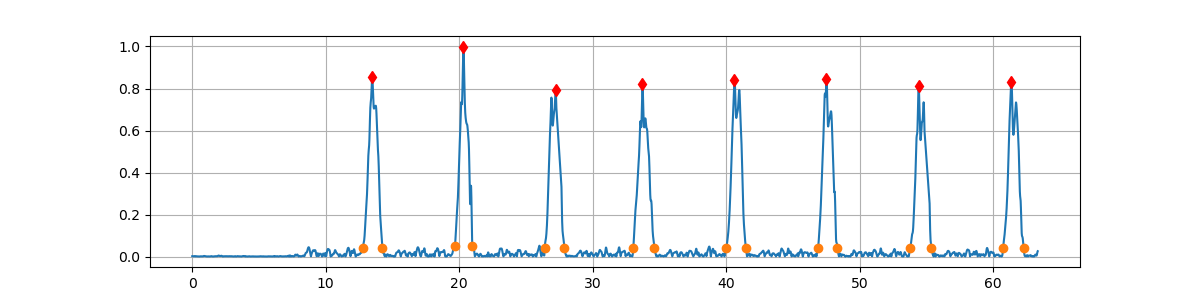

In [4]:
# find_peaks method
from scipy.signal import find_peaks, peak_widths

fps = properties["fps"]

# get the y coord of shoulders (for qualisys x-y plane is horizontal, y coord was forwards/backwards movement)
# TODO: make this 3D, independent from the ground plane
shoulder_R = vGait[kpt_labels.index("right_shoulder"), 1, :]
shoulder_L = vGait[kpt_labels.index("left_shoulder"), 1, :]

shoulder_diff = np.abs(np.diff(shoulder_R - shoulder_L))
shoulder_diff = shoulder_diff / np.nanmax(shoulder_diff)

# Interpolate NaNs in shoulder_diff
if np.any(np.isnan(shoulder_diff)):
    nans = np.isnan(shoulder_diff)
    not_nans = ~nans
    shoulder_diff[nans] = np.interp(
        np.flatnonzero(nans), np.flatnonzero(not_nans), shoulder_diff[not_nans]
    )

# min distance from peak to peak (2 seconds of straight movement) in samples
min_peak_distance = 2 * properties["fps"]

peaks, peak_properties = find_peaks(shoulder_diff, height=0.3, distance=min_peak_distance)
widths, width_heights, left_ips, right_ips = peak_widths(
    x=shoulder_diff, peaks=peaks, rel_height=0.95
)

# mark turning segments as invalid for gait analysis
#TODO: exclude segments with short step lengths (euclidean distande between heels/ankles) 
# festination (like freezing but moving a little) has to be excluded based on the step length
# valid_segments = np.ones_like(vGait[0, 0, :], dtype=str)
# valid_segments = np.full(shape=vGait[0, 0, :].shape, fill_value=str('straight'))
valid_segments = ['straight'] * vGait.shape[2]
# valid_segments = np.asarray(valid_segments)
for left_base, right_base in zip(left_ips, right_ips):
    turn = ['turn'] * (int(np.floor(right_base)) - int(np.ceil(left_base)) +2)
    valid_segments[int(np.floor(left_base)) : int(np.ceil(right_base))] = turn


## Plot results
# time vector in seconds
t = np.arange(0, vGait.shape[2]) / fps
t = t[1:]
plt.close("all")
plt.figure(figsize=(12, 3))
plt.plot(t, shoulder_diff)
plt.plot(peaks / properties["fps"], shoulder_diff[peaks], "rd")
plt.plot(left_ips / fps, width_heights, "C1o")
plt.plot(right_ips / fps, width_heights, "C1o")
plt.grid()
plt.show()

In [57]:
print(left_ips/fps,right_ips/fps)

[12.77725472 19.67310155 26.40230422 33.04451394 40.02622761 46.88595511
 53.78569773 60.74864532] [14.24411668 20.98130216 27.88557649 34.62446832 41.47206649 48.33577905
 55.38644258 62.28427385]


In [ ]:
valid_segments.__len__()

In [ ]:
for frame_idx, v in enumerate(valid_segments):
    print(frame_idx, v)

### 3D angular change method

In [ ]:
v1 = np.array([1,0,0])
v2 = np.array([1,1,0])

v1 = v1/np.linalg.norm(v1)
v2 = v2/np.linalg.norm(v2)
angle = np.arccos(np.clip(np.dot(v1, v2), -1.0, 1.0))
# print(angle, np.rad2deg(angle))
angle, np.rad2deg(angle)


In [7]:
shoulder_L.shape

(3, 6336)

In [24]:
def compute_angle(vector: np.ndarray) -> np.ndarray:
    """
    Computes the angles (in degrees) between a vector's current and previous position.
    Args:
        vector: n-dim input vector
    Returns:
        angles: angle of rotation between vector[i] and vector[i+1] in degrees.

    """
    angles = []
    for frame_idx, current_vector in enumerate(vector):
        if frame_idx < vector.shape[0] - 1:
            next_vector = vector[frame_idx + 1]
            angle = np.rad2deg(np.arccos(np.clip(np.dot(next_vector, current_vector), -1.0, 1.0)))
            angles.append(angle)
        # print(frame_idx,angle, current_vector)

    return np.array(angles)

In [52]:
shoulder_L_unit.shape, vec.shape

((3, 6336), (3, 6336))

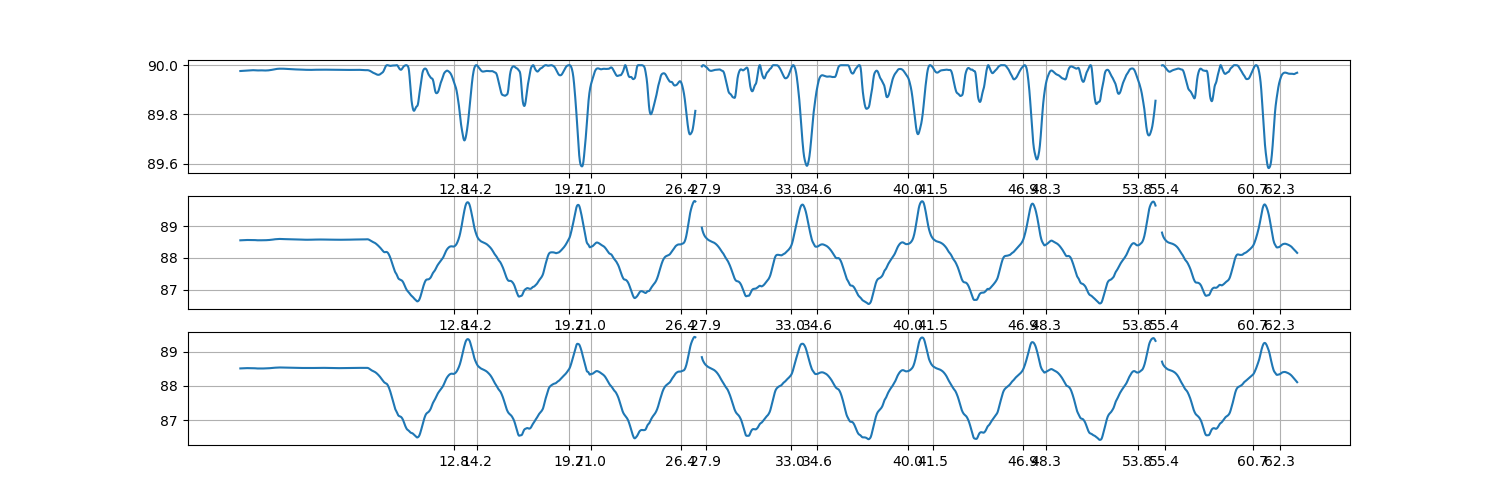

In [64]:
fps = properties["fps"]

# get the y coord of shoulders (for qualisys x-y plane is horizontal, y coord was forwards/backwards movement)
# TODO: make this 3D, independent from the ground plane
shoulder_R = vGait[kpt_labels.index("right_shoulder"), :, :]
shoulder_L = vGait[kpt_labels.index("left_shoulder"), :, :]

shoulder_L_unit = (shoulder_L / np.linalg.norm(shoulder_L, axis=0))
shoulder_R_unit = (shoulder_R / np.linalg.norm(shoulder_R, axis=0))

vec = (shoulder_R_unit-shoulder_L_unit)
# vec = shoulder_R_unit

lsh_angles_dim = []
for dim in range(vec.shape[0]):
    lsh = vec[:dim+1,:]
    angles = compute_angle(lsh.T)
    lsh_angles_dim.append(angles)

t = np.arange(0, vec.shape[1]) / fps

plt.close('all')
plt.figure(figsize=(15,5))

xticks = np.array([12.77725472 ,19.67310155 ,26.40230422, 33.04451394, 40.02622761, 46.88595511,
 53.78569773, 60.74864532 ,14.24411668, 20.98130216, 27.88557649, 34.62446832, 41.47206649, 48.33577905,
 55.38644258, 62.28427385])
for idx, dim in enumerate(lsh_angles_dim,1):

    plt.subplot(3,1,idx)
    plt.plot(t[1:],(dim))
    plt.xticks(np.round(xticks,1))
    plt.grid()




plt.show()

## Gait Event identification

In [ ]:
# first guess with 1 m/s walking speed
ics, fcs, velocity = bruening_ridge_detection(vGait, 1000, 'right', kpt_labels, properties)
ics, fcs, velocity

In [ ]:
# refine the estimate based on initial guess
ICs, FCs, v = bruening_ridge_detection(vGait, velocity, 'right', kpt_labels, properties)
ICs, FCs, v

### Event detection (brüning ridge teardown)

In [ ]:
side = 'right'
velocity = 1000 # mm/s

fs = properties["fps"]
heel_thr = properties["heel_thr"] * velocity
big_toe_thr = properties["toe_thr"] * velocity
# use ankle marker in case the other 2 are not visible
ankle_thr = properties["heel_thr"] * velocity

# Extract trajectories
heel = vGait[kpt_labels.index(f"{side}_heel"), :, :]
big_toe = vGait[kpt_labels.index(f"{side}_big_toe"), :, :]
ankle = vGait[kpt_labels.index(f"{side}_ankle"), :, :]

print(f'heel shape: {heel.shape}, toe shape: {big_toe.shape}, ankle shape: {ankle.shape}')
print(f'heel_thr:  {heel_thr:.2f},\ntoe_thr:   {big_toe_thr:.2f},\nankle_thr: {ankle_thr:.2f}')

In [ ]:
# Compute 3D velocities
heel_vel = np.linalg.norm(np.diff(heel, axis=1), axis=0) * fs
ankle_vel = np.linalg.norm(np.diff(ankle, axis=1), axis=0) * fs
big_toe_vel = np.linalg.norm(np.diff(big_toe, axis=1), axis=0) * fs


# time vector
t = np.arange(0, vGait.shape[2]-1) / fps

# Ground contact detection based on thresholds
ground_contact = (
    (heel_vel < heel_thr) | (ankle_vel < ankle_thr) | (big_toe_vel < big_toe_thr)
).astype(int)

gc_heel = (heel_vel < heel_thr).astype(int)
gc_ankle = (ankle_vel < ankle_thr).astype(int)
gc_toe = (big_toe_vel < big_toe_thr).astype(int)

plt.close("all")
plt.figure(figsize=(12, 4))
for idx, series in enumerate([gc_heel, gc_ankle, gc_toe]):
    plt.subplot(3, 1, idx + 1)
    plt.plot(t, series, alpha=0.5)
# plt.plot(ground_contact)

In [ ]:
plt.close("all")
plt.figure(figsize=(12, 4))
for idx, series in enumerate([heel_vel, ankle_vel, big_toe_vel]):
    plt.subplot(3, 1, idx + 1)
    plt.plot(series, alpha=0.5)

## Plotting

In [ ]:
for id, kpt in enumerate(kpt_labels):
    print(f"{id:2d}: {kpt}")

In [ ]:
for event_type in steps.items():
    print(event_type[0])
    break
    for step in event_type[1]:
        frame, side, straight_walk = step.values()
        break


In [ ]:
kpt_idx = 2

data = vGait
x = data[kpt_idx, 0, :]
y = data[kpt_idx, 1, :]
z = data[kpt_idx, 2, :]

# close all previous plots
plt.close("all")
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")

# all data points
ax.scatter(x, y, z, c = 'b',  s=10, alpha=0.25, label="all points", linewidths=0.5, )
# ax.scatter(0,0,0,c='k',s=50,label='origin')

# plot GEs 
for event_type in steps.items():
    for step in event_type[1]:
        frame, side, straight_walk = step.values()

        if straight_walk and side == "right" and event_type[0] == "IC":
            ax.scatter(x[frame], y[frame], z[frame], s=50, alpha=1, label= frame, marker='d')



        # ax.scatter(x[fc], y[fc], z[fc], c="g", s=100, alpha=1, label="Final Contact")


# highlight ICs and FCs
# ax.scatter(x[ICs], y[ICs], z[ICs], c="r", s=100, alpha=1, label="Initial Contact")
# ax.scatter(x[FCs], y[FCs], z[FCs], c="g", s=100, alpha=1, label="Final Contact")

# ax.scatter(og_data[kpt_idx, 0, :], og_data[kpt_idx, 1, :], og_data[kpt_idx, 2, :], c="k", s=75, label="og data")

# plot the difference between original and interpolated+filtered data
# interpolation_diff = og_data - vGait + og_data
# ax.scatter(diff[kpt_idx,0,:], diff[kpt_idx,1,:], diff[kpt_idx,2,:], c='m', s=75, label='diff data')


# labes, axes, wievs
plt.title(f"{kpt_labels[kpt_idx]}")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_aspect("auto")
ax.set_xlim(-2500, 2500)
ax.set_ylim(-2500, 2500)
ax.set_zlim(0, 2500)
ax.legend()
plt.show()

In [ ]:
ic_events = {step["frame"]: step for step in steps["IC"]}
perspective = ic_events[915].get("perspective", True)
# perspective
# ic_events


# Gait Analysis

In [ ]:
import copy
segments = ["all", "straight", "turn"]
# metrics of interest (for each side)
moi = {
    metric: []
    for metric in [
        "stime",
        "slen",
        "vel",
        "swing",
        "dsupp",
        "bos",
    ]
}

# output data structure
metrics = {
    segment: {
        "left": copy.deepcopy(moi),
        "right": copy.deepcopy(moi),
    }
    for segment in segments
}
for type, sides in metrics.items():
    print(type)
    for side in sides.items():
        print(side)

metrics['all']['left']['stime'].append('1')

for type, sides in metrics.items():
    print(type)
    for side in sides.items():
        print(side)

In [ ]:
segments = ["all", "straight", "turn"]
# metrics of interest (for each side)
moi = {
    metric: []
    for metric in [
        "stime",
        "slen",
        "vel",
        "swing",
        "dsupp",
        "bos",
    ]
}

# output data structure
metrics = {
    segment: {
        "left": copy.deepcopy(moi),
        "right": copy.deepcopy(moi),
    }
    for segment in segments
}


events = steps
ICs = events["IC"]
FCs = events["FC"]

fs = properties["fps"]
stride_min = properties["stride_min"]
stride_max = properties["stride_max"]

# iterate Initial Contact gait events
for i, IC in enumerate(ICs):
    stime, slen, vel, bos, swing, dsupp = (None,None,None,None,None,None)

    print('\n')
    ipsi, contra = IC["side"], "left" if IC["side"] == "right" else "right"

    # get the value of "perspective" key, return "all" if it's empty
    perspective = IC.get("perspective", "all")

    #
    #
    #
    print(IC)
    print(
        f"frame idx: {IC['frame']}, side: {IC['side']}, perspective: {perspective}, ipsi: {ipsi}, contra: {contra} "
    )

    # TODO: make sure this is what is means
    # if perspective is None?
    # if perspective not in perspsectives:
    #     continue

    # get the next ipsilateral event, index it globally (relative to the whole event list), return None otherwise
    same_foot_next_idx = next(
        (j for j, event in enumerate(ICs[i + 1 :], start=i + 1) if event["side"] == ipsi), None
    )
    print(f"same foot next idx: {same_foot_next_idx}")
    # check if event order is correct, filter false positives
    if same_foot_next_idx is not None:

        # stride time = time elapsed between heelstrikes of the same foot
        stime = (ICs[same_foot_next_idx]["frame"] - IC["frame"]) / fs

        #
        #
        #
        print(f"stime: {stime}, {stride_min <= stime <= stride_max}")

        if stride_min <= stime <= stride_max:
            # frame index of current and next IC event
            IC0, IC2 = IC["frame"], ICs[same_foot_next_idx]["frame"]

            # frame index of first contralateral heel strike (between current and next ipsilateral)
            IC1 = get_frame_index(ICs, contra, IC0, IC2)

            FC0, FC1, FC2 = None, None, None

            # if there's a next contralateral heel strike GE
            if IC1:
                IC1 = IC1[0]

                # see gait_events.png
                FC0 = get_frame_index(FCs, contra, IC0, IC1)
                FC1 = get_frame_index(FCs, ipsi, IC1, IC2)
                FC2 = get_frame_index(FCs, ipsi, IC2, IC2 + int(fs * stride_max))

                FC0 = FC0[0] if FC0 else None
                FC1 = FC1[0] if FC1 else None
                FC2 = FC2[0] if FC2 else None

            #
            #
            #
            print(f"Ipsi GEs:")
            print(f"IC (IC0): {IC0}, IC2: {IC2}, FC1: {FC1}, FC2: {FC2}")
            print(f"Contra GEs:")
            print(f"IC1: {IC1}, FC0: {FC0}")

            # if either of the values is None, ignore it
            if any(x is None for x in [IC0, IC1, IC2, FC0, FC1, FC2]):
                continue

            # heel point
            HP0 = np.nanmedian(vGait[kpt_labels.index(f"{ipsi}_heel"), :, IC0:FC0], axis=1)
            HP2 = np.nanmedian(vGait[kpt_labels.index(f"{ipsi}_heel"), :, IC2:FC2], axis=1)
            HP1 = np.nanmedian(vGait[kpt_labels.index(f"{contra}_heel"), :, IC1:FC1], axis=1)

            # stride lenght on xy plane
            slen = np.linalg.norm(HP2[:2] - HP0[:2])
            vel = slen / stime
            bos = np.linalg.norm(np.cross(HP2 - HP1, HP1 - HP0)) / np.linalg.norm(HP2 - HP1)
            swing = (IC2 - FC1) / fs
            dsupp = ((FC0 - IC0) + (FC1 - IC1)) / fs

            print(f"appending: ")
            for pers in ['all',perspective]:
                print(f"pers: {pers}, ipsi: {ipsi}")
                metrics[pers][ipsi]["stime"].append(stime)
                metrics[pers][ipsi]["slen"].append(slen)
                metrics[pers][ipsi]["vel"].append(vel)
                metrics[pers][ipsi]["swing"].append(swing)
                metrics[pers][ipsi]["dsupp"].append(dsupp)
                metrics[pers][ipsi]["bos"].append(bos)

parameters = {}
for state, data in metrics.items():
    parameters[state] = {
        metric: {
            **compute_pooled_stats(data["left"][metric], data["right"][metric]),
            "asymmetry": compute_asymmetry(data["left"][metric], data["right"][metric]),
        }
        for metric in data["left"]
}

In [ ]:
display_results(parameters)

In [ ]:
for state, calclulated_stuff in metrics.items():
    print(state, calclulated_stuff)

### WP

In [ ]:
# save npz file

# out_filename = './filtered_data.npz'
with open(out_filename, 'w') as f:
    np.savez(out_filename, pose_data=vGait, kpt_labels=kpt_labels)